In [1]:
from src import genetic_algorithm,differential_evolution,nsde
from src.repository.mutation import  PolynomialM,DEMutation
from src.repository.selection import DESelectionMO,BinaryTSMO
from src.repository.cross_over import DECrossOver,SimulatedBC
from src.repository.encoding import RealEncoding
from src.repository.population import RealPMO
from src.nsga import NSGAII
from src.Problems import Dtlz
from src.indicators import *
import matplotlib.pyplot as plt
from scipy.stats import ranksums
import numpy as np
import pandas as pd



In [2]:
def plot_single_view(ax, front, objectives, labels, title):
    x = []
    y = []
    z = []
    for solution in front:
        objective_values = objectives(solution.value)
        x.append(objective_values[0])
        y.append(objective_values[1])
        z.append(objective_values[2])

    ax.scatter(x, y, z, marker='o', label=f'Front {len(front)}')
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])
    ax.set_title(title)
    ax.legend()

def plot_pareto_front_3d(front, objectives, title="Pareto-optimal Front", labels=None, m=3):
    fig = plt.figure(figsize=(15, 5))

    ax1 = fig.add_subplot(131, projection='3d')
    plot_single_view(ax1, front, objectives, labels, title)

    ax2 = fig.add_subplot(132, projection='3d')
    plot_single_view(ax2, front, objectives, labels, title)
    ax2.view_init(elev=20, azim=30)  # Set custom viewing angles

    ax3 = fig.add_subplot(133, projection='3d')
    plot_single_view(ax3, front, objectives, labels, title)
    ax3.view_init(elev=45, azim=-30)  # Set custom viewing angles

    #display(fig)

In [3]:
problems_n = [1,2,5,7]
problems = [Dtlz(i) for i in problems_n]
iproblems = [Dtlz(i,True) for i in problems_n]
all_porb = problems + iproblems

In [4]:
from IPython.display import clear_output

results = {'GA':{},
            'DE':{}}
for i in range(30):
    print(i+1)
    
    
 
    for problem in all_porb:
        
        n_iter = 70
        n_pop = 250
        population = RealPMO()  
        encoding = RealEncoding(bounds=problem.bounds)  
        ga_config = genetic_algorithm.GAConfig(n_pop=n_pop, n_iter=n_iter, minimize=True)
        crossover = SimulatedBC(r_cross=1) 
        mutation = PolynomialM(r_mut=1/problem.n) 
        selection = BinaryTSMO()  
        nsga = NSGAII(cross_over=crossover, mutation=mutation, population=population, encoding=encoding, selection=selection, config=ga_config)

        population = RealPMO()  
        encoding = RealEncoding(bounds=problem.bounds)
        de_cross =  DECrossOver()
        de_selection =  DESelectionMO()
        de_mutation =  DEMutation(r_mut=0.45)
        de_config = differential_evolution.DEConfig(n_pop=n_pop,n_iter=n_iter)
        nsdeii = nsde.NSDEII(cross_over=de_cross,mutation=de_mutation,population=population,encoding=encoding,selection=de_selection,config=de_config)

        result_de = nsdeii.run(problem.evaluate)
        result_ga = nsga.run(problem.evaluate)

        clear_output(wait=True)
        try:
            results['GA'][problem.name].append(result_ga)
            results['DE'][problem.name].append(result_de)
        except:

            results['GA'][problem.name] = []
            results['DE'][problem.name] = []


30


In [5]:
df_results = {'GA':{},'DE':{}}

for key in results:
    for key_prob in results[key]:
        r2_values = []
        se_values = []
        for i,front in enumerate(results[key][key_prob]):
            values = [ind.fitness for ind in front]
            df_results[key][key_prob] = {}
            W = [[1/3,1/3,1/3],[1/5,1/5,3/5],[1/4,1/4,2/4]]
            r2 = r2_indicator(values,W)
            se = calculate_s_energy(values)
            r2_values.append(r2)
            se_values.append(se)

        df_results[key][key_prob]['r2'] = r2_values
        df_results[key][key_prob]['se'] = se_values

df = pd.concat({k: pd.concat({kk: pd.DataFrame(vv) for kk, vv in v.items()}, axis=1) for k, v in df_results.items()}, axis=1)
df.tail()



GA                                                                \
       dtlz1                   dtlz2                   dtlz5                 
          r2            se        r2            se        r2            se   
24  1.855618  3.211026e+05  0.293158  2.822875e+05  0.926278  2.094737e+05   
25  3.116350  6.360542e+04  0.316761  6.867520e+06  1.082926  2.122916e+06   
26  5.975573  4.435993e+14  0.316788  2.277059e+05  0.974049  2.549323e+05   
27  2.768077  1.956844e+16  0.299040  8.535466e+05  0.622016  6.554489e+05   
28  3.473759  8.378123e+04  0.306536  1.328063e+06  0.673718  1.078034e+17   

                                            ...        DE                \
       dtlz7         idtlz1                 ...     dtlz7                 
          r2   se        r2             se  ...        r2            se   
24  1.911111  0.0  8.157691   49288.569537  ...  1.911119  1.808861e+07   
25  1.911111  0.0  6.536616   48719.004352  ...  1.911111  0.000000e+00   
26  1.911111  0.0  8.516686  453285.487508  ...  1.914444  1.212865e+06   
27  1.911111  0.0  6.592988  114498.830446  ...  1.911111  0.000000e+00   
28  1.911111  0.0  8.211467   33976.103822  ...  1.911111  0.000000e+00   

                                                                             \
       idtlz1                 idtlz2                  idtlz5                  
           r2           se        r2            se        r2             se   
24  15.156050   345.272177 -0.339978  61865.456765 -0.305105  148805.671905   
25  11.643335   396.689983 -0.318135  61093.500556 -0.346852   83568.986659   
26  14.856116  1286.847923 -0.341018  58783.732702 -0.282202  100450.095373   
27  17.084437  3541.913984 -0.345949  58507.791129 -0.321101  100369.234058   
28  12.049465     8.943880 -0.349732  62395.642428 -0.333146   82150.837773   

                             
       idtlz7                
           r2            se  
24 -11.049895  26223.078369  
25 -11.049895  25934.086767  
26 -11.049895  29334.636145  
27 -11.049895  25511.267570  
28 -11.049895  25339.752259  

[5 rows x 32 columns]

In [6]:
def compare_algorithms(df):
    algorithms = df.columns.levels[0]
    problems = df.columns.levels[1]
    metrics = df.columns.levels[2]

    for problem in problems:
        print(f"Problem: {problem}")
        for metric in metrics:
            print(f"Metric: {metric}")
            data = [df[(algorithm, problem, metric)].dropna() for algorithm in algorithms]
            print("Mean:")
            print([np.mean(d) for d in data])
            print("Standard Deviation:")
            print([np.std(d) for d in data])
            print("Wilcoxon rank-sum test:")
            print(ranksums(*data))
        print()

compare_algorithms(df)


Problem: dtlz1
Metric: r2
Mean:
[3.737110339632753, 6.6277520433353345]
Standard Deviation:
[1.2242792053866045, 1.2387535165329875]
Wilcoxon rank-sum test:
RanksumsResult(statistic=-5.761755587069961, pvalue=8.324348589084817e-09)
Metric: se
Mean:
[1.1375064381776558e+16, 987.5854498247149]
Standard Deviation:
[2.983873628019957e+16, 1507.834800570959]
Wilcoxon rank-sum test:
RanksumsResult(statistic=6.523769146493518, pvalue=6.856221015936947e-11)

Problem: dtlz2
Metric: r2
Mean:
[0.3113526231336583, 0.26276012932471715]
Standard Deviation:
[0.016931103975530038, 0.0005685789919014915]
Wilcoxon rank-sum test:
RanksumsResult(statistic=6.539320443624611, pvalue=6.179898682749156e-11)
Metric: se
Mean:
[3.8134380858858936e+16, 163655.9155076942]
Standard Deviation:
[1.3580649044403024e+17, 2622.201323085347]
Wilcoxon rank-sum test:
RanksumsResult(statistic=3.3824071260127297, pvalue=0.0007185356938181474)

Problem: dtlz5
Metric: r2
Mean:
[0.9212457762224056, 0.6123279913356094]
Standard 

In [7]:

def find_closest_to_mean(df):
    closest_to_mean = {}
    for algorithm in df.columns.levels[0]:
        closest_to_mean[algorithm] = {}
        for problem in df[algorithm].columns.levels[0]:
            mean_r2 = df[algorithm][problem]['r2'].mean()
            absolute_difference_function = lambda list_value : abs(list_value - mean_r2)
            closest_value = min(df[algorithm][problem]['r2'].tolist(), key=absolute_difference_function)
            closest_to_mean[algorithm][problem] = df[algorithm][problem]['r2'][df[algorithm][problem]['r2'] == closest_value].index[0]
    return closest_to_mean

res = find_closest_to_mean(df)


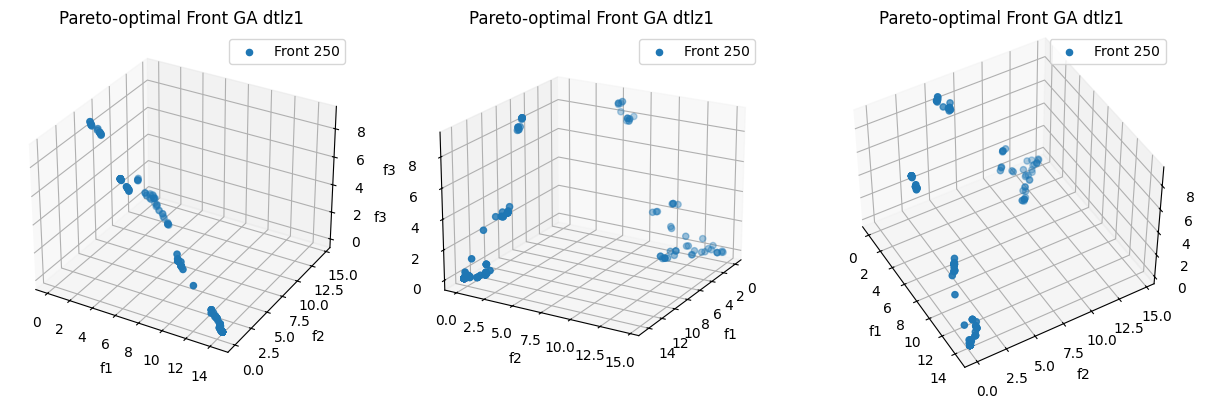

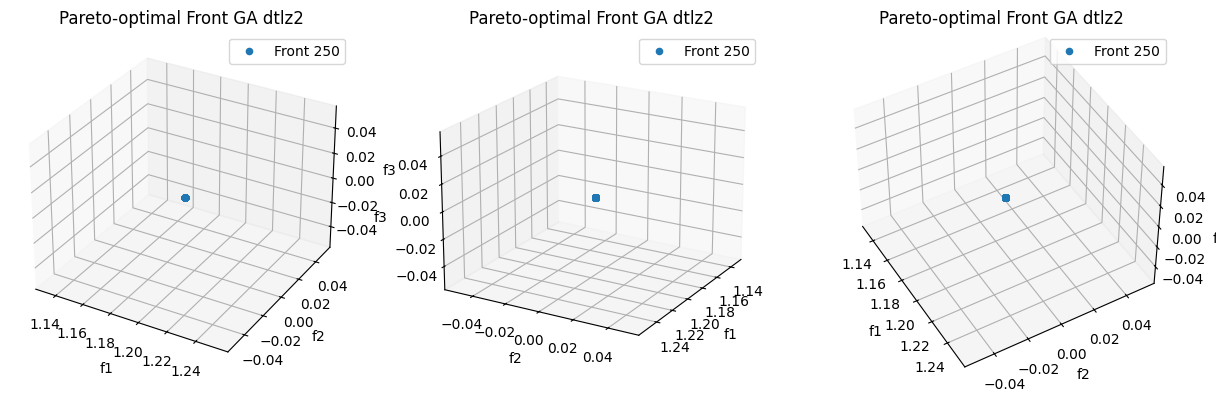

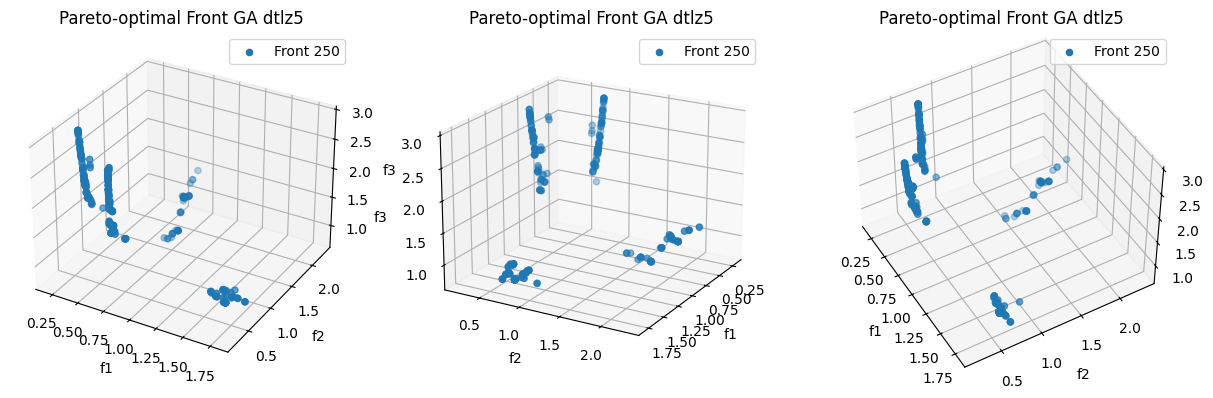

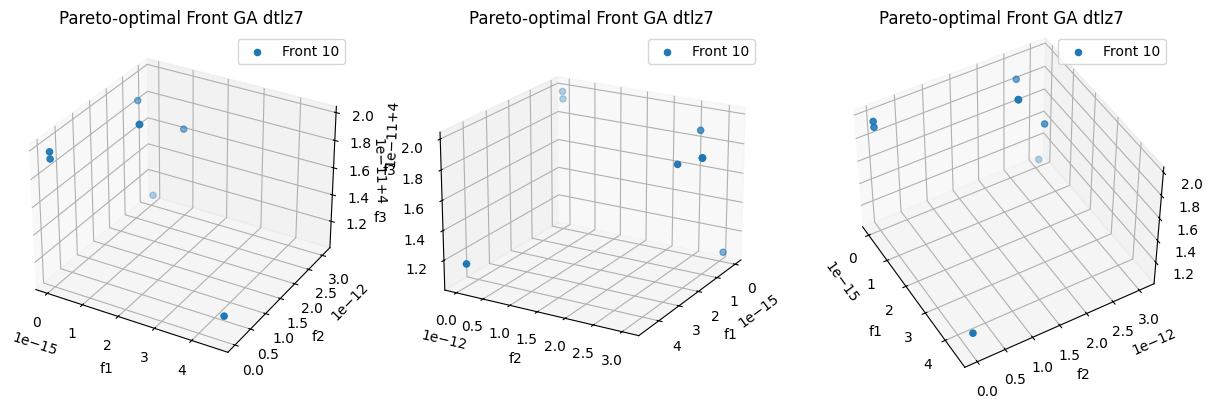

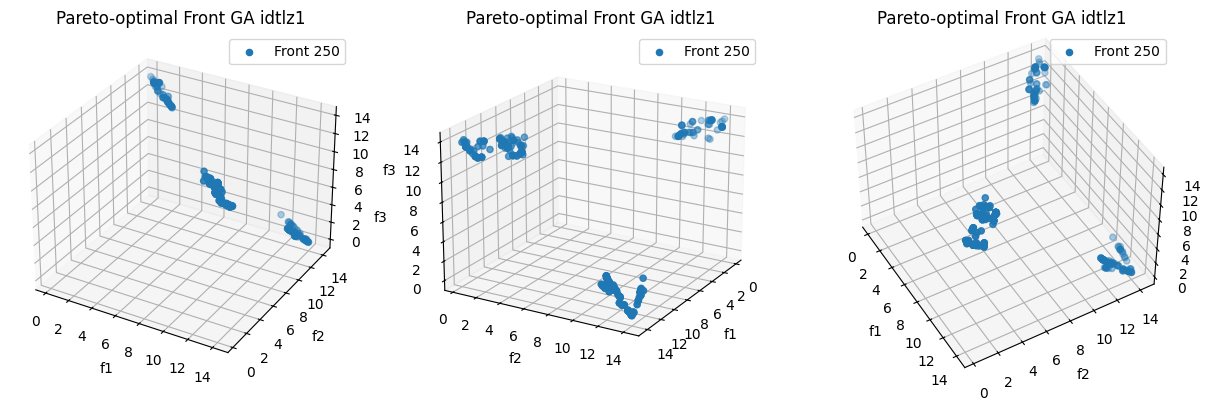

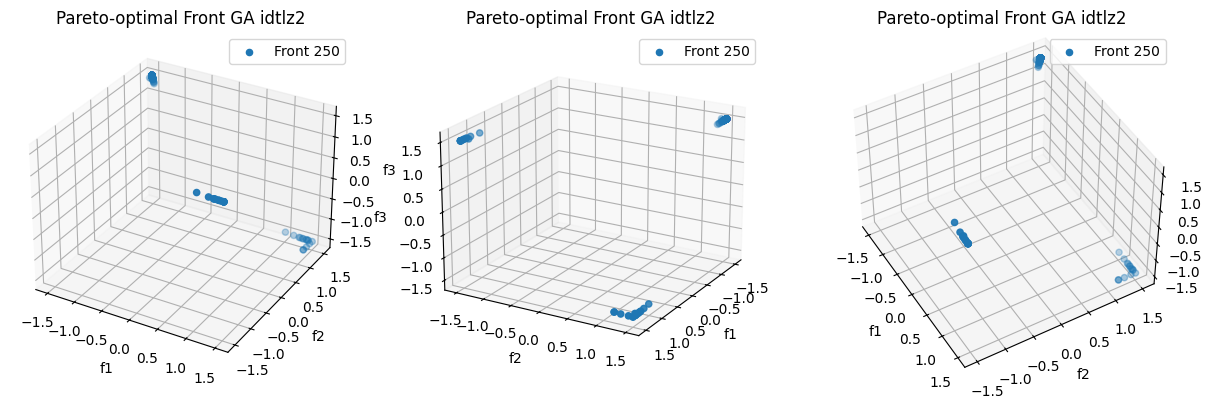

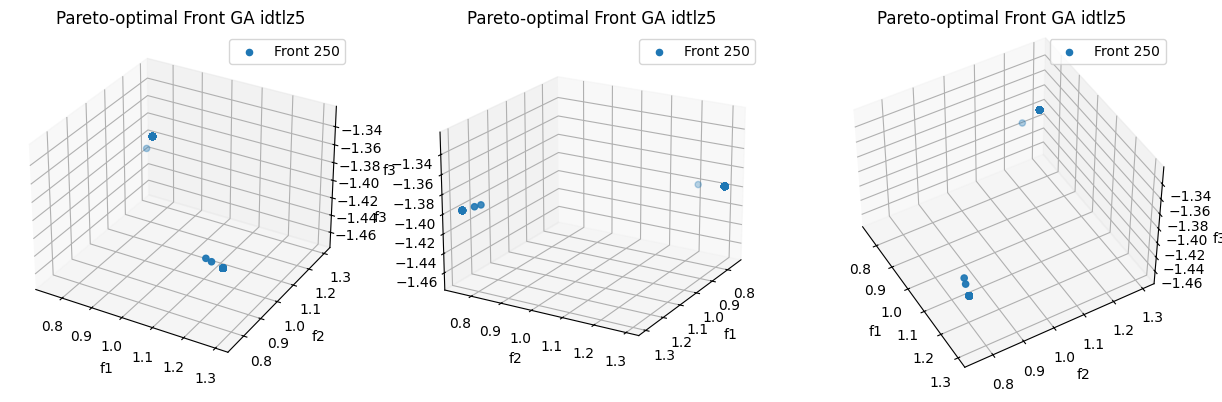

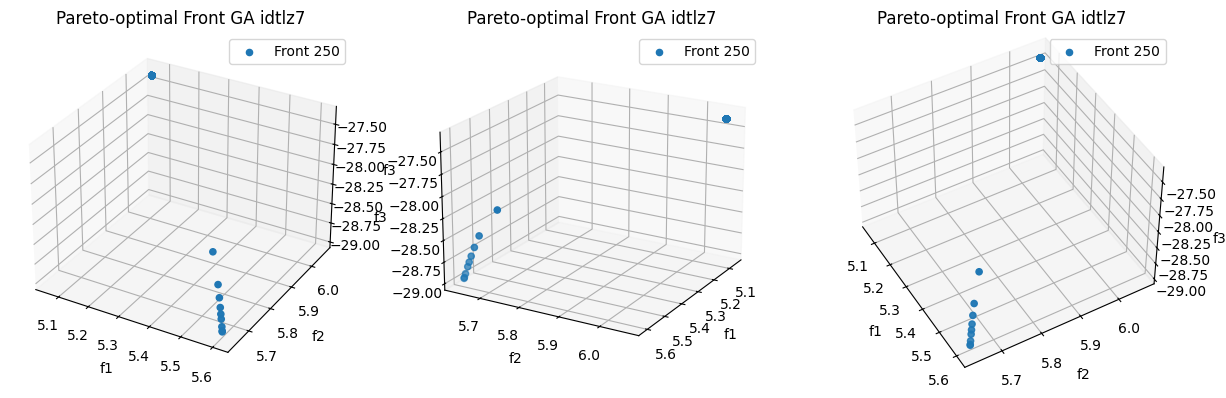

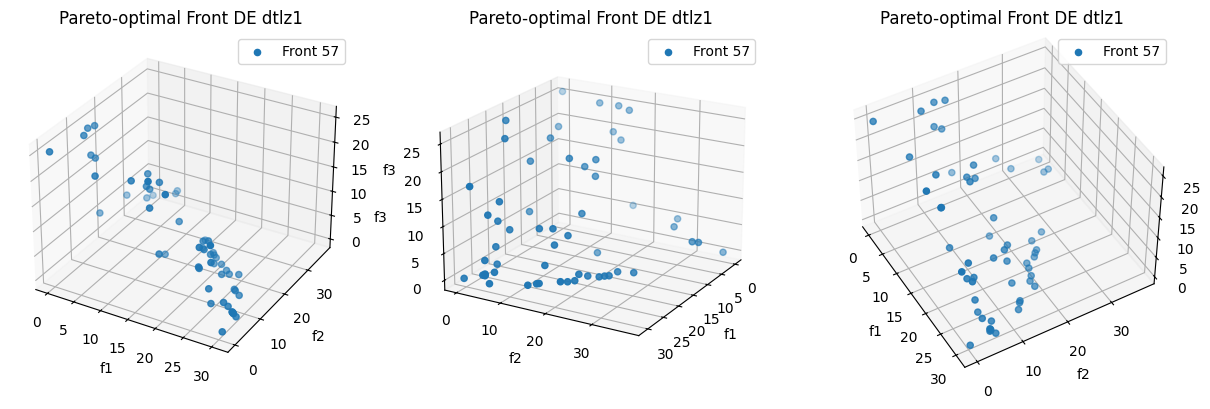

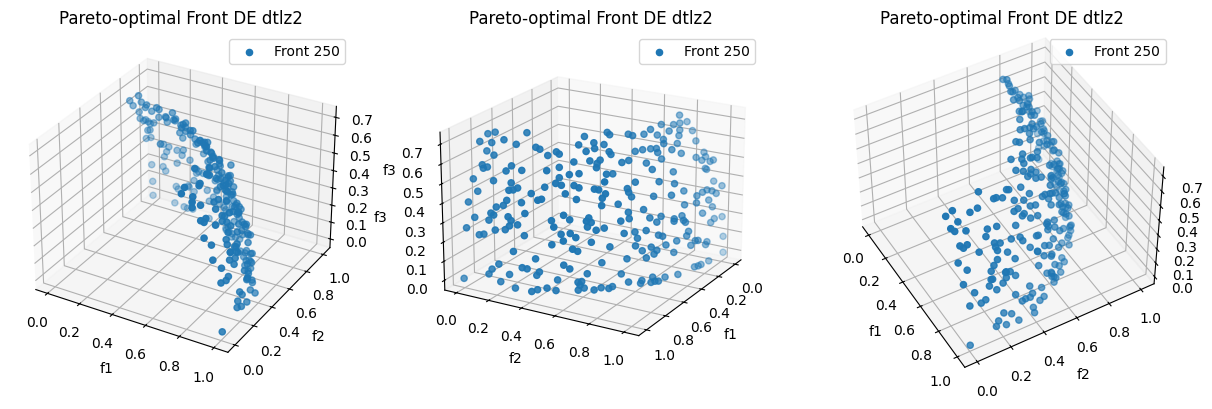

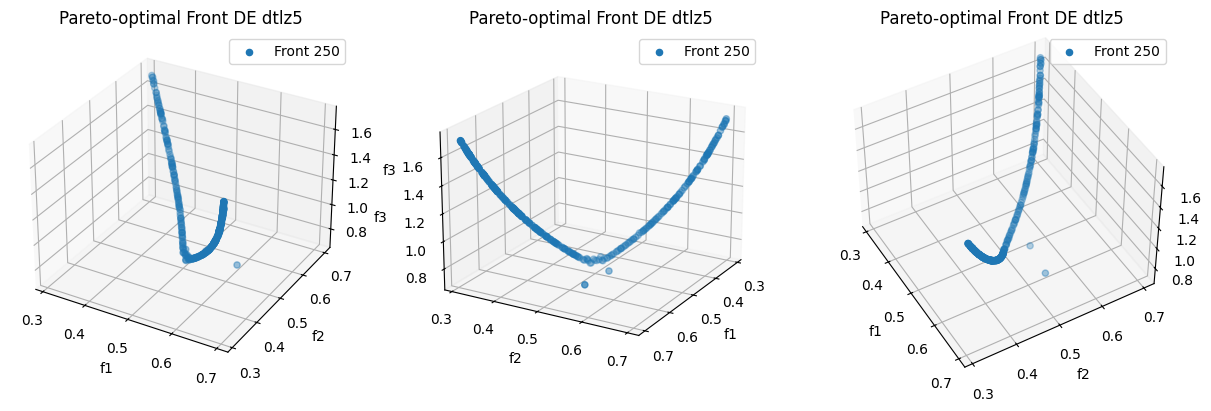

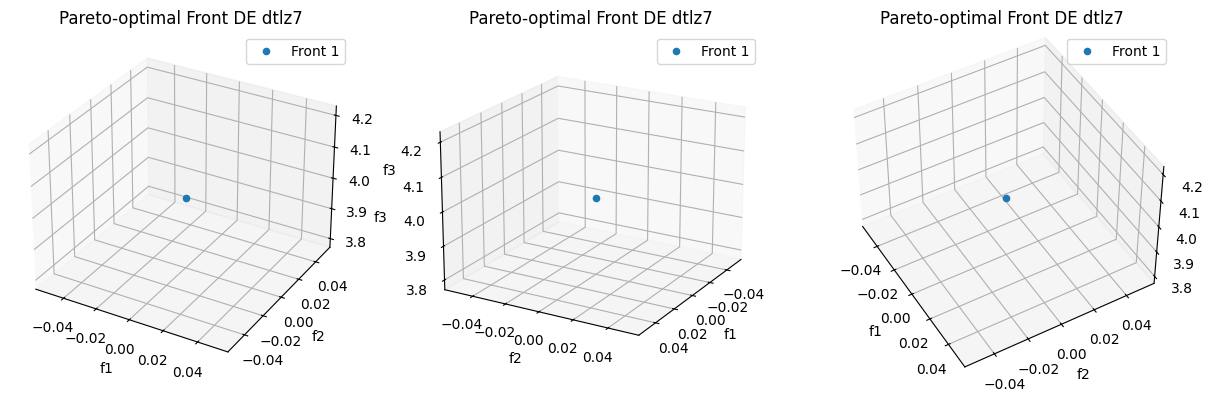

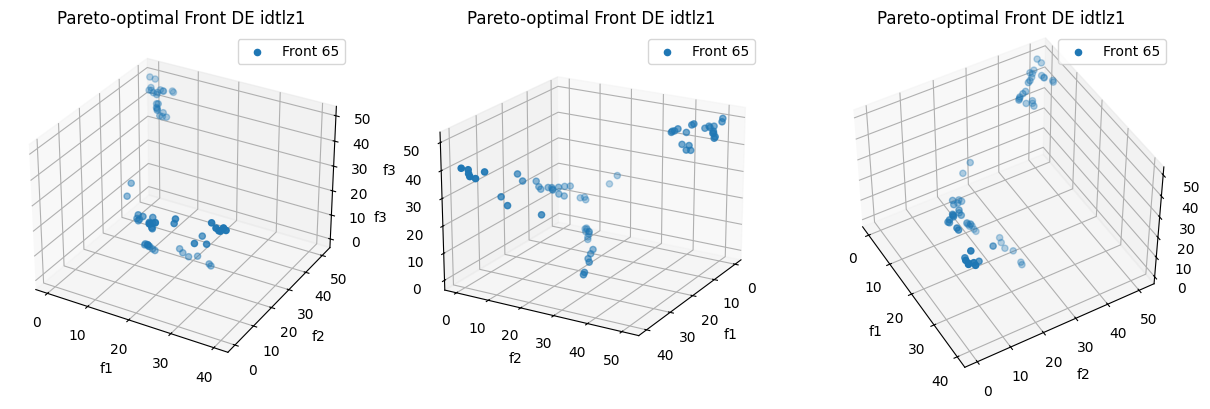

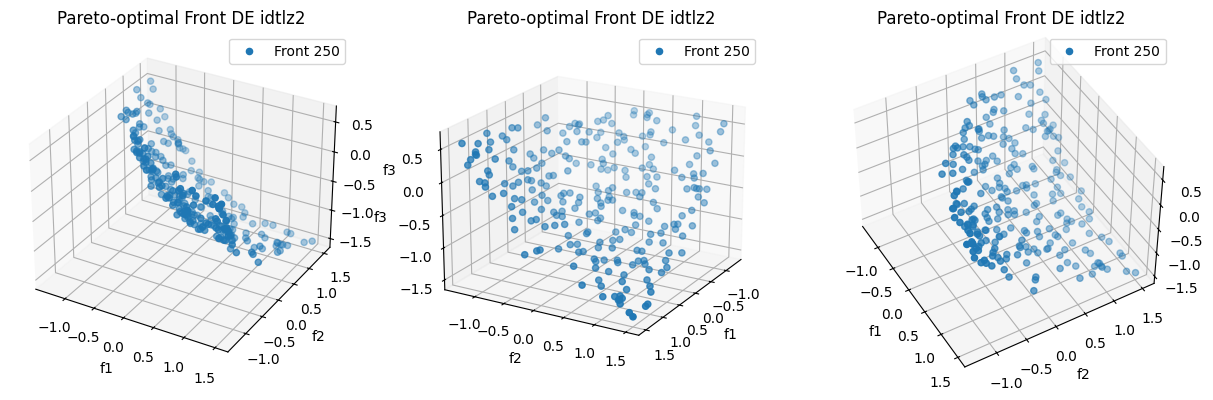

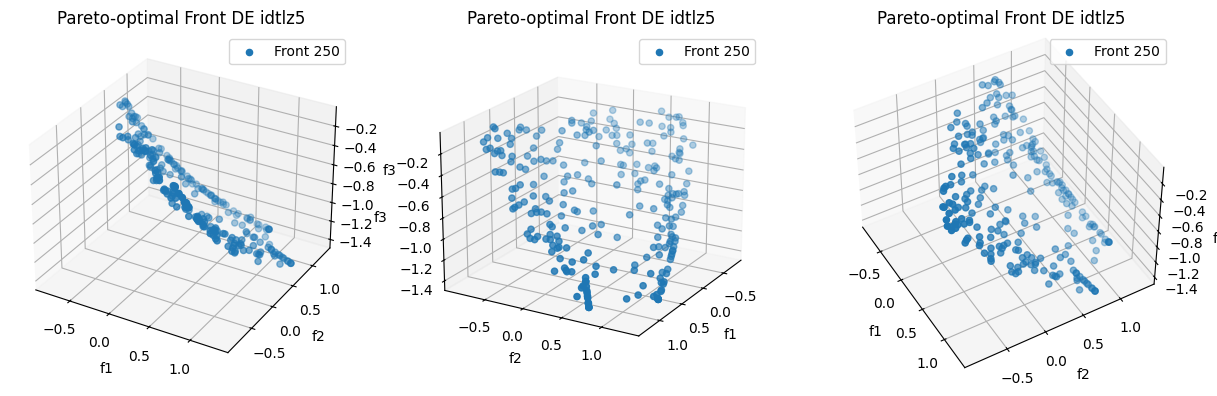

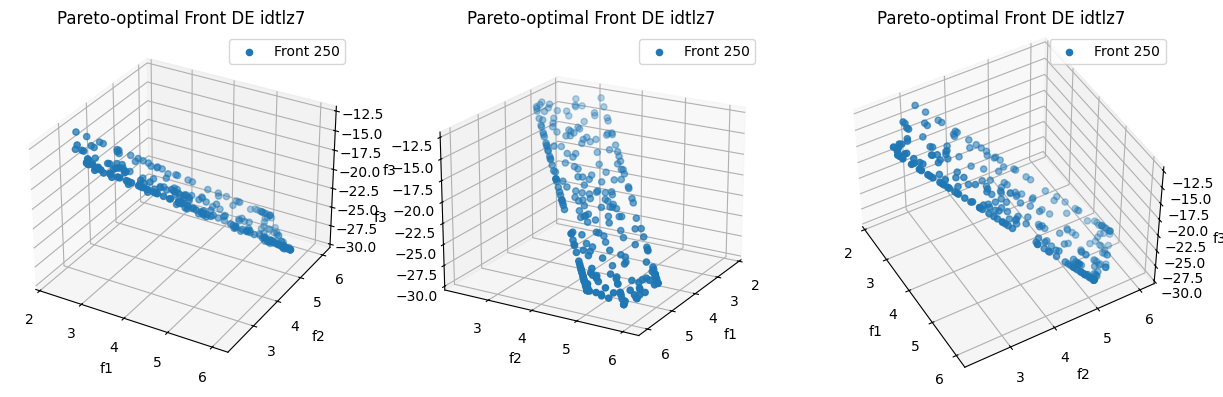

In [8]:
for key_alg in res:
    for problem in all_porb:
        i = res[key_alg][problem.name]
        
        plot_pareto_front_3d(results[key_alg][problem.name][i], problem.evaluate, title="Pareto-optimal Front "+ key_alg+' '+problem.name, labels=['f1','f2','f3'])
